In [240]:
import numpy as np
import cv2 # OpenCV biblioteka
import matplotlib
import matplotlib.pyplot as plt
import collections
import math

In [241]:
%matplotlib inline 
matplotlib.rcParams['figure.figsize'] = 16,12

In [242]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from tensorflow.keras.optimizers import SGD
from sklearn.cluster import KMeans

In [243]:
number_indexes = []
symbol_indexes = []

symbols = False
for i in range(104):
    if i>94 and i%4 == 0:
        symbols = not symbols
    elif (i%8 == 0):
        symbols = not symbols
    
    if symbols:
        number_indexes.append(i)
    else:
        symbol_indexes.append(i)

In [244]:
def resize_region(region):
    return cv2.resize(region, (28, 28), interpolation=cv2.INTER_NEAREST)

In [245]:
# sortiranje kontura
def get_y(node):
    return node[1][1]

def get_x(node):
    return node[1][0]

def sort_nodes(nodes):
    sorted_list = []
    while len(nodes) != 0:
        nodes.sort(key=get_y)
        first_eight = nodes[0:8]
        if len(nodes) <= 8:
            first_eight = nodes[0:4]
        for contour in first_eight:
            nodes.remove(contour)
        first_eight.sort(key=get_x)
        for i in range(len(first_eight)):
            sorted_list.append(first_eight[i])
            
    return sorted_list

In [246]:
def image_processing(image_path):
    img = cv2.imread(image_path) #ucitavamo sliku
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #prebacujemo je u rgb model
    img = img_rgb[207:650, 100:1450] #crop-ujemo sliku    650  207:257
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) #prebacujemo sliku u crno-belu
    
    ret, image_otsu = cv2.threshold(img_gray, 0, 255, cv2.THRESH_OTSU) # pomocu Otsu-a dobijamo binarnu sliku
    contours, hierarchy = cv2.findContours(image_otsu, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE) #nalazimo sve konture
     
    contours_cards = [] # izdvajamo samo potrebne konture
    for contour in contours:
        center, size, angle = cv2.minAreaRect(contour) 
        width, height = size
        if width > 5 and width < 30 and height > 5 and height < 30: 
            contours_cards.append(contour) 

    img_contours = img.copy()
    selected_contours = [] # vadimo samo konture po kolonama koje nam trebaju
    for contour in contours_cards:
        contour_ok = False
        for mini_contour in contour:
            if mini_contour[0][0] > 25 and mini_contour[0][0] < 51:
                contour_ok = True
            elif mini_contour[0][0] > 190 and mini_contour[0][0] < 225:
                contour_ok = True
            elif mini_contour[0][0] > 355 and mini_contour[0][0] < 395:
                contour_ok = True
            elif mini_contour[0][0] > 525 and mini_contour[0][0] < 560:
                contour_ok = True
            elif mini_contour[0][0] > 695 and mini_contour[0][0] < 730:
                contour_ok = True
            elif mini_contour[0][0] > 865 and mini_contour[0][0] < 900:
                contour_ok = True
            elif mini_contour[0][0] > 1030 and mini_contour[0][0] < 1065:
                contour_ok = True
            elif mini_contour[0][0] > 1200 and mini_contour[0][0] < 1235:
                contour_ok = True
            else:
                contour_ok = False
                break
        if contour_ok == True:
            selected_contours.append(contour)

    # img_regions = img.copy() # sortiramo konture za kraj po x-osi
    sorted_regions = [] 
    sorted_regions_numbers = []
    sorted_regions_symbols = [] 
    regions_array = []
    i = 0
    n= len(selected_contours)
    numbers = True

    #sredjujemo 10 da bude jedna a ne dve konture
    while i < n:
        contour = selected_contours[i]
        x, y, w, h = cv2.boundingRect(contour)
        area = cv2.contourArea(contour)
        if area > 55 and w < h + 5:
            j = i + 1
            while j < len(selected_contours):
                next_contour = selected_contours[j]
                x1, y1, w1, h1 = cv2.boundingRect(next_contour)
                if x1 == x + w or x == x1 + w1 or x1 == x + w + 1 or x == x1 + w1 + 1:
                    if x1 > x:
                        w = x1 - x  + w1
                        selected_contours.pop(i)
                        n-=1
                    else:
                        w = w1 + w
                        x = x1
                        selected_contours.pop(j)
                        n-=1
                j+=1
             
            region = image_otsu[y:y+h+1, x:x+w+1]
            regions_array.append([resize_region(region), (x, y, w, h)])
        i+=1

    #SORTIRAMO REGIONE
    regions_array = sort_nodes(regions_array) 
    #na dve slike cemo crtati konture, na jednoj samo brojeve, a na drugoj simbole karata
    img_numbers = img.copy()
    img_symbols = img.copy()
    for i in range(len(regions_array)):
        x = regions_array[i][1][0]
        y = regions_array[i][1][1]
        w = regions_array[i][1][2]
        h = regions_array[i][1][3]
        regions = regions_array[i][0]
        if number_indexes.count(i) != 0:
            cv2.rectangle(img_numbers, (x, y), (x + w, y + h), (0, 255, 0),  2)
            sorted_regions_numbers.append(resize_region(region))
        else:
            cv2.rectangle(img_symbols, (x, y), (x + w, y + h), (0, 255, 0),  2)
            sorted_regions_symbols.append(resize_region(region))
       
    return img_numbers, sorted_regions_numbers, img_symbols, sorted_regions_symbols

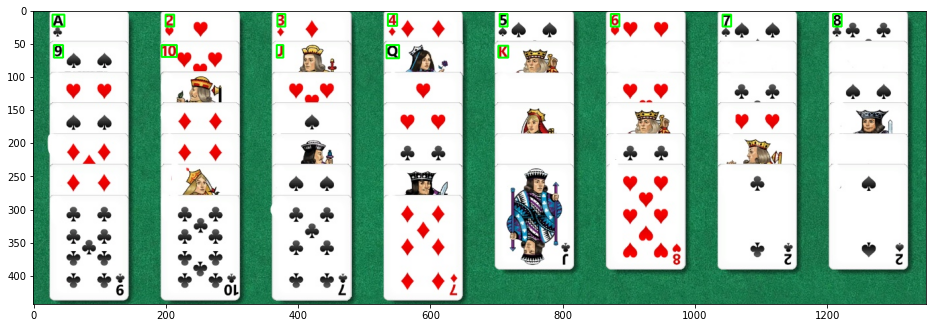

In [247]:
# ucitavamo sliku, pronalazimo konture i oznacavamo ih
img_numbers, numbers, img_symbols, symbols = image_processing("training/training2.jpg")
display_image(img_numbers)  # img_numbers za oznacene brojeve, img_symbols za boje

In [248]:
# first_column = img_contours[:, 25:51]
# second_column = img_contours[:, 195: 220]
# third_column = img_contours[:, 360:390]
# fourth_column = img_contours[:, 530: 555]
# fifth_column = img_contours[:, 700: 725]
# sixth_column = img_contours[:, 870: 895]
# seventh_column = img_contours[:, 1035: 1060]
# eight_column = img_contours[:, 1205: 1230]

In [249]:
# priprema podataka za obucavcanje
def scale_to_range(image):
    return image/255

def matrix_to_vector(image):
    return image.flatten()

def prepare_for_ann(regions):
    ready_for_ann = []
    for region in regions:
        scale = scale_to_range(region)
        ready_for_ann.append(matrix_to_vector(scale))
    return ready_for_ann

def convert_output(alphabet):
    nn_outputs = []
    for index in range(len(alphabet)):
        output = np.zeros(len(alphabet))
        output[index] = 1
        nn_outputs.append(output)
    return np.array(nn_outputs)

In [250]:
# neuronska mreza

def create_ann(output_size):
    ann = Sequential()
    ann.add(Dense(128, input_dim=784, activation='sigmoid'))
    ann.add(Dense(output_size, activation='sigmoid'))
    return ann

def train_ann(ann, X_train, y_train, epochs):
    X_train = np.array(X_train, np.float32) # dati ulaz
    y_train = np.array(y_train, np.float32) # zeljeni izlazi na date ulaze
    
    print("\nTraining started...")
    sgd = SGD(learning_rate=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)
    ann.fit(X_train, y_train, epochs=epochs, batch_size=1, verbose=0, shuffle=False)
    print("\nTraining completed...")
    return ann

def winner(output):
    return max(enumerate(output), key=lambda x: x[1])[0]


In [251]:
# prikaz rezultata
def display_result(outputs, alphabet):
    result = []
    for output in outputs:
        result.append(alphabet[winner(output)])
    return result

In [252]:
def display_image(image, color=False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')

In [253]:
# H = herc
# P = pik
# T = tref
# R = karo


Training started...

Training completed...


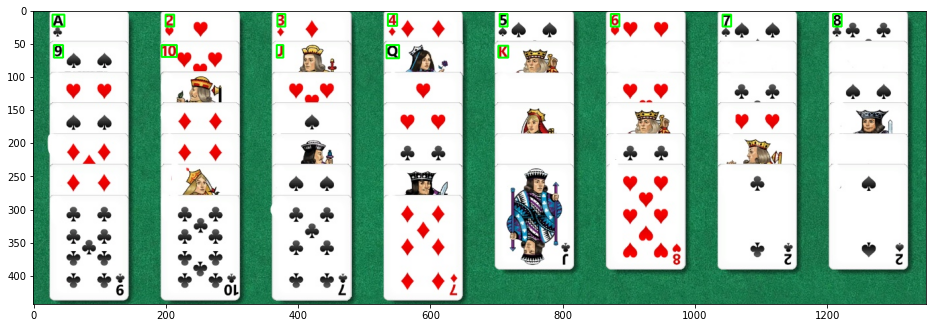

In [256]:
#treniranje mreze
selected_numbers, numbers, selected_symbols, symbols = image_processing("training/training2.jpg")
display_image(selected_numbers)

# alphabet_numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14]
alphabet_numbers = ['A', '2', '3', '4', '5', '6', '7','8', 
                    '9', '10', 'J','Q', 'K']

inputs = prepare_for_ann(numbers)
outputs = convert_output(alphabet_numbers)
ann = create_ann(output_size=13)
ann = train_ann(ann, inputs, outputs, epochs=2000)

In [255]:
result = ann.predict(np.array(inputs[2:4], np.float32))
print(result)
print("\n")
print(display_result(result, alphabet_numbers))

1/1 [==============================] - 0s 40ms/step
[[0.07585136 0.07611553 0.07612235 0.07638598 0.0764523  0.07662209
  0.07664549 0.07666302 0.076653   0.07653402 0.07646028 0.07645848
  0.07616524]
 [0.07585136 0.07611553 0.07612235 0.07638598 0.0764523  0.07662209
  0.07664549 0.07666302 0.076653   0.07653402 0.07646028 0.07645848
  0.07616524]]


[' 8', ' 8']


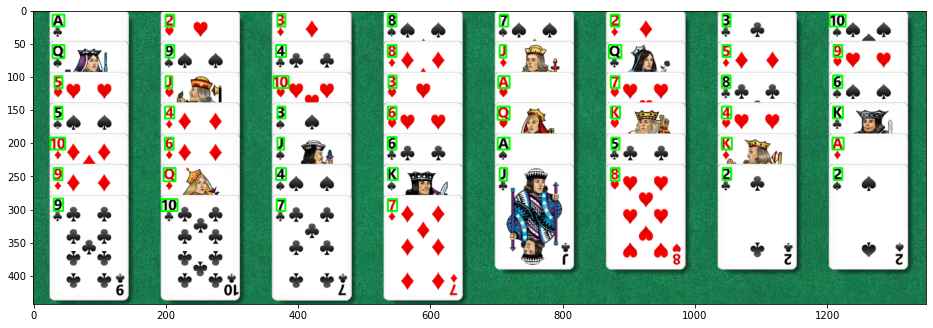

In [209]:
img_numbers_test, numbers_test, img_symbols_test, symbols_test =  image_processing("training/1.png")
display_image(img_numbers_test)

# test_inputs =  prepare_for_ann(numbers_test)
# result = ann.predict(np.array(numbers_test, np.float32))
# print("Results:")
# print(display_result(result, alphabet_numbers))

